<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Load-alignment-data" data-toc-modified-id="Load-alignment-data-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Load alignment data</a></span></li><li><span><a href="#Copy-filtered-slide-images-to-new-folder" data-toc-modified-id="Copy-filtered-slide-images-to-new-folder-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Copy filtered-slide images to new folder</a></span></li><li><span><a href="#Using-docarray-to-construct" data-toc-modified-id="Using-docarray-to-construct-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Using <code>docarray</code> to construct</a></span></li><li><span><a href="#Baseline-models-construction" data-toc-modified-id="Baseline-models-construction-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Baseline models construction</a></span></li><li><span><a href="#Training-set-and-Testing-set-spilt" data-toc-modified-id="Training-set-and-Testing-set-spilt-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Training set and Testing set spilt</a></span></li><li><span><a href="#Model-Implementation" data-toc-modified-id="Model-Implementation-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Model Implementation</a></span><ul class="toc-item"><li><span><a href="#Text-wise" data-toc-modified-id="Text-wise-6.1"><span class="toc-item-num">6.1&nbsp;&nbsp;</span>Text-wise</a></span><ul class="toc-item"><li><span><a href="#Naive-Bayes-(Textual)" data-toc-modified-id="Naive-Bayes-(Textual)-6.1.1"><span class="toc-item-num">6.1.1&nbsp;&nbsp;</span>Naive Bayes (Textual)</a></span></li><li><span><a href="#Evaluation-Textual-Results" data-toc-modified-id="Evaluation-Textual-Results-6.1.2"><span class="toc-item-num">6.1.2&nbsp;&nbsp;</span>Evaluation Textual Results</a></span></li></ul></li><li><span><a href="#Visual-wise" data-toc-modified-id="Visual-wise-6.2"><span class="toc-item-num">6.2&nbsp;&nbsp;</span>Visual-wise</a></span><ul class="toc-item"><li><span><a href="#Naive-Bayes-(Visual)" data-toc-modified-id="Naive-Bayes-(Visual)-6.2.1"><span class="toc-item-num">6.2.1&nbsp;&nbsp;</span>Naive Bayes (Visual)</a></span></li><li><span><a href="#Evaluation-Visual-Results" data-toc-modified-id="Evaluation-Visual-Results-6.2.2"><span class="toc-item-num">6.2.2&nbsp;&nbsp;</span>Evaluation Visual Results</a></span></li></ul></li></ul></li></ul></div>

In [1]:
from typing import List
from docarray import dataclass, Document, DocumentArray
from docarray.typing import Image, Text, JSON, URI
import ast
import pandas as pd
import os
import numpy as np
import platform
import shutil

is_windows = platform.system().lower() == 'windows'
if is_windows:
    source_dir = "C:\\Users\\Kun\\Desktop" 
else:
    source_dir = "/Users/kun-lin/Desktop"
source_dir = os.path.join(source_dir, f"Angebot")
dest_dir = "output"
PPTtoImg_dir = os.path.join(dest_dir, f"PPTtoImg")
fWordImg_dir = os.path.join(dest_dir, f"FewWordImg")
ct_fWordImg_dir = os.path.join(fWordImg_dir, f"CT_FewWordImg")
topshapetype_dir = os.path.join(dest_dir, f"TopShapeTypeImg")
labels_dir = os.path.join(dest_dir, f"LABELS")
checkpoint_path = os.path.join(dest_dir, f"checkpoints")

if not os.path.exists(dest_dir):
    os.makedirs(dest_dir)
if not os.path.exists(PPTtoImg_dir):
    os.makedirs(PPTtoImg_dir)
if not os.path.exists(fWordImg_dir):
    os.makedirs(fWordImg_dir)
if not os.path.exists(ct_fWordImg_dir):
    os.makedirs(ct_fWordImg_dir)  
if not os.path.exists(topshapetype_dir):
    os.makedirs(topshapetype_dir)
if not os.path.exists(labels_dir):
    os.makedirs(labels_dir)
if not os.path.exists(checkpoint_path):
    os.makedirs(checkpoint_path)

# Load alignment data

In [2]:

def convert_to_list(data):
    return ast.literal_eval(data)
# Since it take too much time on traversal ppt files, Easily to import the dataframe from the csv file
df_da = pd.read_csv('alignment_pptx_list.csv', converters={'shape_type': convert_to_list})
# for Mac OS
if not is_windows:
    df_da['file_name'] = df_da['file_name'].apply(lambda x: x.replace('C\\Users\\Kun\\Desktop\\Angebot', source_dir))
    df_da['file_name'] = df_da['file_name'].apply(lambda x: x.replace('\\', '/'))

df_da = df_da[~df_da['contents'].isnull()]
df_da.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 26468 entries, 0 to 26467
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   file_name   26468 non-null  object
 1   page_num    26468 non-null  int64 
 2   shape_type  26468 non-null  object
 3   contents    26468 non-null  object
dtypes: int64(1), object(3)
memory usage: 1.0+ MB


In [3]:
# filter out less than 4 words
df_da['word_count'] = df_da['contents'].apply(lambda x: len(str(x).split()) if pd.notna(x) else 0)
df_few_words = df_da[~(df_da['word_count'] <= 4)]
df_few_words.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 23148 entries, 0 to 26467
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   file_name   23148 non-null  object
 1   page_num    23148 non-null  int64 
 2   shape_type  23148 non-null  object
 3   contents    23148 non-null  object
 4   word_count  23148 non-null  int64 
dtypes: int64(2), object(3)
memory usage: 1.1+ MB


In [4]:
df_json = pd.read_json(os.path.join(labels_dir, "1620_annotations.json"))
df_json['choice'].value_counts()

Others                         544
Working Package Examples       202
Working Package Description    190
Reference Details              137
Consultant Profile             106
Offer Title                     91
Working Package Overview        90
Project Calculation             85
Initial & Target Situation      60
Reference Overview              43
Competencies                    42
Target Situation                17
Initial Situation               13
Name: choice, dtype: int64

In [5]:
df_json['page_num'] = df_json['image'].apply(lambda x: int(x.split('.')[0].split('_')[-1]))
df_json['image'] = df_json['image'].apply(lambda x: x.split('.')[0].split('-')[1])


In [6]:
df_json['image'][0]

'9578_9578_PPM_Rollout_project_outline_16'

In [7]:
# be aware of path difference between Windows and Mac OS
df_few_words['label'] = ''

for i in range(len(df_json)):
    item = df_json.iloc[i]
    f_name = item['image']
    page = int(df_json.at[i, 'page_num'])
    ktr = f_name.split('_')[0]

    df_few_words.loc[(df_few_words['file_name'].str.contains(ktr)) & (df_few_words['page_num'] == page), 'label'] = item['choice']

C:\Users\Kun\AppData\Local\Temp\ipykernel_16952\297909455.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_few_words['label'] = ''


In [8]:
df_few_words.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 23148 entries, 0 to 26467
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   file_name   23148 non-null  object
 1   page_num    23148 non-null  int64 
 2   shape_type  23148 non-null  object
 3   contents    23148 non-null  object
 4   word_count  23148 non-null  int64 
 5   label       23148 non-null  object
dtypes: int64(2), object(4)
memory usage: 1.2+ MB


In [9]:
df_few_words['label'].value_counts()

                               21528
Others                           544
Working Package Examples         202
Working Package Description      190
Reference Details                137
Consultant Profile               106
Offer Title                       91
Working Package Overview          90
Project Calculation               85
Initial & Target Situation        60
Reference Overview                43
Competencies                      42
Target Situation                  17
Initial Situation                 13
Name: label, dtype: int64

# Copy filtered-slide images to new folder 

In [ ]:
def delete_png_files(directory):
    for filename in os.listdir(directory):
        filepath = os.path.join(directory, filename)
        if os.path.isfile(filepath) and filename.lower().endswith(".PNG"):
            os.remove(filepath)

In [7]:
# copy filtered-data to new folder(FewWordImg)
delete_png_files(fWordImg_dir)
uni_path = df_few_words['file_name'].unique()

for path in uni_path:
    for idx, row in df_few_words[df_few_words['file_name'] == path].iterrows():
        # print(row['file_name'])
        exec_path = os.path.abspath(PPTtoImg_dir)  # image output path
        if is_windows:
            # for windows OS
            ktr = row['file_name'].split('\\')[-2]
        else:
            # for Mac OS
            ktr = row['file_name'].split('/')[-2]
        name = os.path.basename(row['file_name'])
        name = name.split('.')[0]
        name = '_'.join([ktr, name, "%d.PNG" % row['page_num']])
        imgpath = os.path.join(exec_path, name)
        
        # from PPTtoImg to FewWordImg
        shutil.copy(imgpath, os.path.join(os.getcwd(), fWordImg_dir))

> This process is to ignore **Chapter Covers** images so that we make them labeling easier

# Using `docarray` to construct

In [10]:
@dataclass
class MySlide:
    Content: Text #chunk
    ImgPath: Image #chunk
    ShapeType: List[str] #tag
    PageNum: int #tag
    Label: str #tag

@dataclass
class MyPPT:
    FileName: Text
    Slide: List[MySlide]

group_slide = DocumentArray()
uni_path = df_few_words['file_name'].unique()

for path in uni_path:
    for idx, row in df_few_words[df_few_words['file_name'] == path].iterrows():
        # print(row['file_name'])
        exec_path = os.path.abspath(fWordImg_dir)  # filter-images output path
        if is_windows:
            # for windows OS
            ktr = row['file_name'].split('\\')[-2]
        else:
            # for Mac OS
            ktr = row['file_name'].split('/')[-2]
        name = os.path.basename(row['file_name'])
        name = name.split('.')[0]
        name = '_'.join([ktr, name, "%d.PNG" % row['page_num']])
        imgpath = os.path.join(exec_path, name)
        # imgpath = os.path.join(image_dir_path, )
        
        m = MySlide(
                    Content = row['contents'],
                    ImgPath = imgpath,
                    ShapeType = row['shape_type'],
                    PageNum = row['page_num'],
                    Label = row['label']
                )
        
        group_slide.append(Document(m))
            
docPPT = Document(MyPPT(FileName = path, Slide = group_slide))

In [12]:
docPPT_1620 = Document(MyPPT(FileName=docPPT.FileName, Slide=[d for d in docPPT.Slide if d.tags['Label'] != '']))

# Baseline models construction

In [13]:
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.preprocessing import LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import chi2
from sklearn.feature_selection import SelectKBest
from sklearn.model_selection import StratifiedKFold, RepeatedStratifiedKFold, cross_val_score, train_test_split, GridSearchCV

from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.metrics import log_loss

import matplotlib.pyplot as plt
import seaborn as sns

In [14]:
# This function will print the metrcis for diffeent model
def print_model_report(y_test, prediction, ML_modelName):
    print("Model report for: "+ ML_modelName + "\n")
    print(classification_report(y_test, prediction, digits=4))
    
    
# Show confusion matrix plot
def plot_confusion_matrix(y_test, prediction, ML_modelName, cmap):
    cm = confusion_matrix(y_test, prediction)
    
    ax = sns.heatmap(cm, 
              annot=True, 
              annot_kws={'size':18,'weight':'normal'},
              fmt='.20g', 
              cmap=cmap, 
              cbar_kws={'shrink':1},
              linewidths=2)
    
    plt.title("Confusion Matrix for: " + ML_modelName)
    plt.ylabel("Actual Label")
    plt.xlabel("Predict Label")
    cbar = ax.collections[0].colorbar
    plt.show()
    
    
def stratifiedVD(X_train, y_train, ex_model):
    #StratifiedKFold is a variation of KFold
    SKF = StratifiedKFold(n_splits=10, random_state=42, shuffle=True).split(X_train, y_train)
    
    score_list = []
    for k, (train, test) in enumerate(SKF):

        print(train.shape, test.shape)
        # instantiate the model
        ex_model.fit(X_train.iloc[train], y_train.iloc[train])
        # calculate the score each fold
        score = ex_model.score(X_train.iloc[test], y_train.iloc[test])
        score_list.append(score)

        print(f'Fold: {k+1:2d}, Class dist.: {np.bincount(y_train.iloc[train])}, Acc: {score:.3f}')    

    print(f'\nCV accuracy: {np.mean(score_list):.3f} +/- {np.std(score_list):.3f}')
    

def evaluate_model(X, y, pipline):
    # instantiate the model
    RSKF = RepeatedStratifiedKFold(n_splits=10, random_state=42, n_repeats=3)
    scores = cross_val_score(pipline, X, y, cv= RSKF, scoring='accuracy', n_jobs=-1)
    return scores


def roc_auc_score_multiclass(actual_class, pred_class, average = "macro"):
    
    #creating a set of all the unique classes using the actual class list
    unique_class = set(actual_class)
    roc_auc_dict = {}
    for per_class in unique_class:
        
        #creating a list of all the classes except the current class 
        other_class = [x for x in unique_class if x != per_class]

        #marking the current class as 1 and all other classes as 0
        new_actual_class = [0 if x in other_class else 1 for x in actual_class]
        new_pred_class = [0 if x in other_class else 1 for x in pred_class]

        #using the sklearn metrics method to calculate the roc_auc_score
        # roc_auc = roc_auc_score(new_actual_class, new_pred_class, average = average)
        roc_auc = roc_auc_score(new_actual_class, new_pred_class, average= average , multi_class="ovr")

        roc_auc_dict[per_class] = roc_auc

    return roc_auc_dict

# Training set and Testing set spilt

In [15]:
dict_augment = {'ori':docPPT.Slide, 'slide_1620':docPPT_1620.Slide}

In [16]:

class AppInfo:
    textual_info = "Textual"
    visual_info = "Visual"
    both_info = "Both"

# given textual or visual information as X variable and the category as y variable
def get_X_y_set(dict_aug, app_info: AppInfo = "Textual"):
    dict_ = dict()
    for str, da in dict_aug.items():

        if app_info == AppInfo.textual_info:
            X = da['@.[Content]'].to_dataframe().text
        elif app_info == AppInfo.visual_info:
            shape_types = [slide.tags['ShapeType'] for slide in da]
            shape_series = pd.Series(shape_types)
            X = shape_series
        # elif app_info == AppInfo.both_info:

        y = pd.Series([slide.tags['Label'] for slide in da])
        print(str, X.shape, y.shape)
        dict_[str] = pd.DataFrame({'X': X, 'y':y})    
        
    return dict_

dict_X_y = get_X_y_set(dict_augment, app_info=AppInfo.visual_info)

ori (23148,) (23148,)
slide_1620 (1620,) (1620,)


In [17]:
keys = 'slide_1620'
dict_X_y[keys]['y'].value_counts()

Others                         544
Working Package Examples       202
Working Package Description    190
Reference Details              137
Consultant Profile             106
Offer Title                     91
Working Package Overview        90
Project Calculation             85
Initial & Target Situation      60
Reference Overview              43
Competencies                    42
Target Situation                17
Initial Situation               13
Name: y, dtype: int64

In [18]:
# Train and Test data splits
labelencoder = LabelEncoder()
dict_X_y[keys]['y'] = labelencoder.fit_transform(dict_X_y[keys]['y'])
X_train, X_test, y_train, y_test = train_test_split(dict_X_y[keys]['X'], dict_X_y[keys]['y'], test_size=0.2, 
                                                    stratify=dict_X_y[keys]['y'], random_state=42, shuffle=True)

In [19]:
dict_X_y[keys]['y'].value_counts()

5     544
11    202
10    190
7     137
1     106
4      91
12     90
6      85
2      60
8      43
0      42
9      17
3      13
Name: y, dtype: int64

In [20]:
dict_X_y[keys]['y']

0        4
1        5
2        5
3        1
4        4
        ..
1615     7
1616     7
1617     2
1618    12
1619     5
Name: y, Length: 1620, dtype: int32

# Model Implementation

## Text-wise

In [20]:
# bag of words for chi square
# vectorize_cal = CountVectorizer(max_df= 0.85, min_df=2)
vectorize_cal = CountVectorizer()
sparse_matrix = vectorize_cal.fit_transform(X_train, y_train)

df_bow=pd.DataFrame(sparse_matrix.toarray(), columns=vectorize_cal.get_feature_names_out())

k_best_cal = SelectKBest(score_func = chi2, k = 1600)
best_matrix = k_best_cal.fit(df_bow, y_train)

cols = best_matrix.get_support(indices=True)
features_df_new = df_bow.iloc[:,cols]
features_df_new

,01012021,05,1020,112,113,11311,11595,12281,1272,13043,...,öffentliche,ökosystems,über,überarbeitet,überführung,übergeordnetes,überlastung,überschrift,übersicht,überzeugten
0,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,2,0,0,0,0,0,0,1
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1291,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1292,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1293,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1294,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### Naive Bayes (Textual)

In [21]:
pipeline_nb_t = Pipeline([('vect', CountVectorizer()),
                        ('chi', SelectKBest(score_func = chi2, k = 1600)),
                        ('tfidf', TfidfTransformer()),
                        ('model', MultinomialNB())])


model_nb_t = pipeline_nb_t.fit(X_train, y_train)


### Evaluation Textual Results

In [22]:
stratifiedVD(X_train, y_train, model_nb_t)

(1166,) (130,)
Fold:  1, Class dist.: [ 31  77  43   9  65 391  61  99  30  13 137 145  65], Acc: 0.623
(1166,) (130,)
Fold:  2, Class dist.: [ 31  77  43   9  65 391  61  99  30  13 137 145  65], Acc: 0.577
(1166,) (130,)
Fold:  3, Class dist.: [ 30  77  43   9  66 391  61  99  31  13 136 145  65], Acc: 0.562
(1166,) (130,)
Fold:  4, Class dist.: [ 30  77  44   9  66 391  61  99  31  13 136 144  65], Acc: 0.569
(1166,) (130,)
Fold:  5, Class dist.: [ 30  76  44   9  66 391  61  99  31  12 137 145  65], Acc: 0.554
(1166,) (130,)
Fold:  6, Class dist.: [ 30  76  43   9  66 392  61  99  31  12 137 145  65], Acc: 0.492
(1167,) (129,)
Fold:  7, Class dist.: [ 31  76  43   9  66 392  62  99  31  12 137 145  64], Acc: 0.527
(1167,) (129,)
Fold:  8, Class dist.: [ 31  76  43   9  66 392  62  99  31  12 137 145  64], Acc: 0.589
(1167,) (129,)
Fold:  9, Class dist.: [ 31  76  43   9  66 392  61  99  30  13 137 145  65], Acc: 0.581
(1167,) (129,)
Fold: 10, Class dist.: [ 31  77  43   9  65 392  

In [23]:
pred_nb_t = model_nb_t.predict(X_test)

Model report for: Naive Bayes (Textual)

              precision    recall  f1-score   support

           0     0.0000    0.0000    0.0000         8
           1     1.0000    0.1905    0.3200        21
           2     0.0000    0.0000    0.0000        12
           3     0.0000    0.0000    0.0000         3
           4     1.0000    0.9444    0.9714        18
           5     0.4430    0.9633    0.6069       109
           6     1.0000    1.0000    1.0000        17
           7     1.0000    0.2963    0.4571        27
           8     0.0000    0.0000    0.0000         9
           9     0.0000    0.0000    0.0000         3
          10     0.6400    0.4211    0.5079        38
          11     0.7500    0.2195    0.3396        41
          12     1.0000    0.2222    0.3636        18

    accuracy                         0.5556       324
   macro avg     0.5256    0.3275    0.3513       324
weighted avg     0.6307    0.5556    0.4922       324



c:\Users\Kun\miniconda3\envs\UNITY39\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Kun\miniconda3\envs\UNITY39\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Kun\miniconda3\envs\UNITY39\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


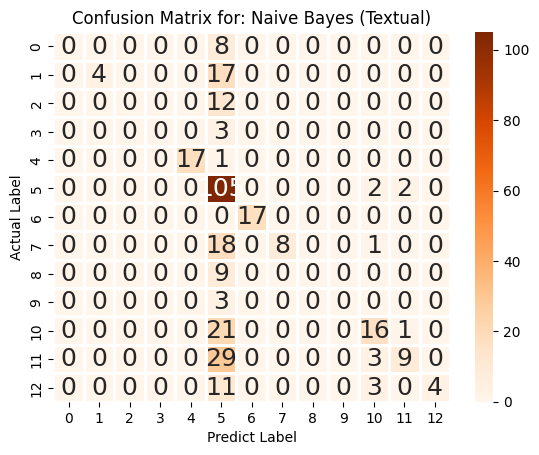

{0: 0.5,
 1: 0.5952380952380952,
 2: 0.5,
 3: 0.5,
 4: 0.9722222222222222,
 5: 0.6746746319607424,
 6: 1.0,
 7: 0.6481481481481481,
 8: 0.5,
 9: 0.5,
 10: 0.6947920500552079,
 11: 0.6044557442040851,
 12: 0.6111111111111112}

In [24]:
print_model_report(y_test, pred_nb_t, "Naive Bayes (Textual)")
plot_confusion_matrix(y_test, pred_nb_t, "Naive Bayes (Textual)", plt.cm.Oranges)
roc_auc_score_multiclass(y_test, pred_nb_t)

## Visual-wise

In [21]:
types = ['AUTO_SHAPE', 'CALLOUT', 'CANVAS', 'CHART',
        'COMMENT', 'DIAGRAM', 'EMBEDDED_OLE_OBJECT', 'FORM_CONTROL',
        'FREEFORM', 'GROUP', 'IGX_GRAPHIC', 'INK', 'INK_COMMENT',
        'LINE', 'LINKED_OLE_OBJECT', 'LINKED_PICTURE', 'MEDIA',
        'OLE_CONTROL_OBJECT', 'PICTURE', 'PLACEHOLDER', 'SCRIPT_ANCHOR',
        'TABLE', 'TEXT_BOX', 'TEXT_EFFECT', 'WEB_VIDEO', 'MIXED']

mlb = MultiLabelBinarizer(classes=types)
onehot = mlb.fit_transform(X_train)
df_shapes = pd.DataFrame(onehot, columns=mlb.classes_, index=X_train.index)
df_shapes

,AUTO_SHAPE,CALLOUT,CANVAS,CHART,COMMENT,DIAGRAM,EMBEDDED_OLE_OBJECT,FORM_CONTROL,FREEFORM,GROUP,...,MEDIA,OLE_CONTROL_OBJECT,PICTURE,PLACEHOLDER,SCRIPT_ANCHOR,TABLE,TEXT_BOX,TEXT_EFFECT,WEB_VIDEO,MIXED
1154,1,0,0,0,0,0,1,0,0,0,...,0,0,1,1,0,0,1,0,0,0
284,1,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,1,0,0,0
1376,1,0,0,0,0,0,0,0,1,1,...,0,0,1,1,0,0,1,0,0,0
466,1,0,0,0,0,0,1,0,1,1,...,0,0,1,1,0,0,1,0,0,0
1222,1,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
648,1,0,0,0,0,0,1,0,0,1,...,0,0,1,1,0,0,1,0,0,0
1227,1,0,0,0,0,0,1,0,0,1,...,0,0,1,0,0,0,1,0,0,0
1379,1,0,0,0,0,0,1,0,1,1,...,0,0,1,1,0,0,1,0,0,0
835,1,0,0,0,0,0,0,0,0,0,...,0,0,1,1,0,0,1,0,0,0


### Naive Bayes (Visual)

In [23]:
from sklearn.base import BaseEstimator, TransformerMixin

class MultiLabelBinarizerTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, classes):
        self.mlb = MultiLabelBinarizer(classes=classes)
    
    def fit(self, X, y=None):
        self.mlb.fit(X)
        return self
    
    def transform(self, X):
        return self.mlb.transform(X)

pipeline_nb_v = Pipeline([
    ('mlb_transformer', MultiLabelBinarizerTransformer(classes=types)),
    ('model', MultinomialNB())
])

model_nb_v = pipeline_nb_v.fit(X_train, y_train)

In [ ]:
# column_transformer = ColumnTransformer([
#     ('vect', TfidfVectorizer(), 'Content'),  # 对 'Content' 列应用 TfidfVectorizer
#     ('mlb', MultiLabelBinarizer(classes=types), 'ShapeType')  # 对 'ShapeType' 列应用 MultiLabelBinarizer
# ])

pipeline_nb_v = Pipeline([('vect', MultiLabelBinarizer(classes=types)),
                          ('model', MultinomialNB())])


model_nb_v = pipeline_nb_v.fit(X_train, y_train)

### Evaluation Visual Results

In [24]:
stratifiedVD(X_train, y_train, model_nb_v)

(1166,) (130,)
Fold:  1, Class dist.: [ 31  77  43   9  65 391  61  99  30  13 137 145  65], Acc: 0.385
(1166,) (130,)
Fold:  2, Class dist.: [ 31  77  43   9  65 391  61  99  30  13 137 145  65], Acc: 0.415
(1166,) (130,)
Fold:  3, Class dist.: [ 30  77  43   9  66 391  61  99  31  13 136 145  65], Acc: 0.423
(1166,) (130,)
Fold:  4, Class dist.: [ 30  77  44   9  66 391  61  99  31  13 136 144  65], Acc: 0.377
(1166,) (130,)
Fold:  5, Class dist.: [ 30  76  44   9  66 391  61  99  31  12 137 145  65], Acc: 0.408
(1166,) (130,)
Fold:  6, Class dist.: [ 30  76  43   9  66 392  61  99  31  12 137 145  65], Acc: 0.377
(1167,) (129,)
Fold:  7, Class dist.: [ 31  76  43   9  66 392  62  99  31  12 137 145  64], Acc: 0.388
(1167,) (129,)
Fold:  8, Class dist.: [ 31  76  43   9  66 392  62  99  31  12 137 145  64], Acc: 0.372
(1167,) (129,)
Fold:  9, Class dist.: [ 31  76  43   9  66 392  61  99  30  13 137 145  65], Acc: 0.403
(1167,) (129,)
Fold: 10, Class dist.: [ 31  77  43   9  65 392  

In [25]:
pred_nb_v = model_nb_v.predict(X_test)

Model report for: Naive Bayes (Visual)

              precision    recall  f1-score   support

           0     0.0000    0.0000    0.0000         8
           1     0.9412    0.7619    0.8421        21
           2     0.0000    0.0000    0.0000        12
           3     0.0000    0.0000    0.0000         3
           4     0.0000    0.0000    0.0000        18
           5     0.3636    0.9908    0.5320       109
           6     0.0000    0.0000    0.0000        17
           7     1.0000    0.2222    0.3636        27
           8     0.0000    0.0000    0.0000         9
           9     0.0000    0.0000    0.0000         3
          10     0.3333    0.0263    0.0488        38
          11     0.0000    0.0000    0.0000        41
          12     0.0000    0.0000    0.0000        18

    accuracy                         0.4043       324
   macro avg     0.2029    0.1539    0.1374       324
weighted avg     0.3058    0.4043    0.2696       324



c:\Users\Kun\miniconda3\envs\UNITY39\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Kun\miniconda3\envs\UNITY39\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Kun\miniconda3\envs\UNITY39\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


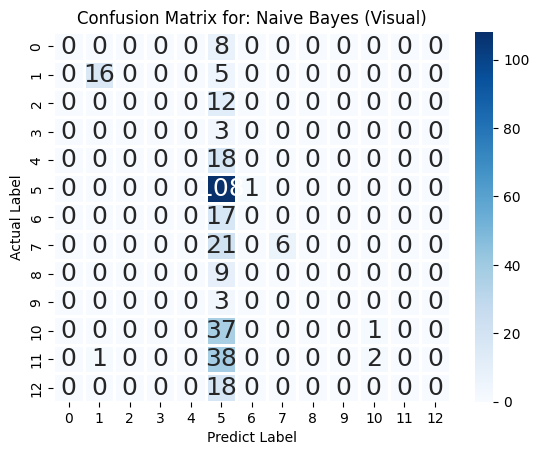

{0: 0.5,
 1: 0.8793022159358792,
 2: 0.5,
 3: 0.5,
 4: 0.5,
 5: 0.5558779603157671,
 6: 0.498371335504886,
 7: 0.6111111111111112,
 8: 0.5,
 9: 0.5,
 10: 0.5096613912403387,
 11: 0.5,
 12: 0.5}

In [26]:
print_model_report(y_test, pred_nb_v, "Naive Bayes (Visual)")
plot_confusion_matrix(y_test, pred_nb_v, "Naive Bayes (Visual)", plt.cm.Blues)
roc_auc_score_multiclass(y_test, pred_nb_v)